In [599]:
# Kaggle Competitions: Outflow of user (DeepLearningSchool)
# https://www.kaggle.com/competitions/advanced-dls-spring-2021

In [ ]:
# Install library
!pip install catboost
!pip install xgboost

In [601]:
# imports
import pandas as pd
import numpy as np
import re

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Load data

In [602]:
# pathes/filenames
PATH_PROJECT = ""
PATH_DATASET = PATH_PROJECT + "dataset/"

train_filename = PATH_DATASET + "train.csv"
test_filename = PATH_DATASET + "test.csv"
submission_filename = PATH_DATASET + "test_submission.csv"

In [603]:
# Load dataset
outflow_users_df = pd.read_csv(train_filename)
test_outflow_users_df = pd.read_csv(test_filename)

# Numeric columns
num_cols = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
# Categorical columns
cat_cols = ['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 
           'HasPhoneService',
           'HasMultiplePhoneNumbers', 
           'HasInternetService', 
           'HasOnlineSecurityService', 
           'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV',
           'HasMovieSubscription','HasContractPhone', 'IsBillingPaperless', 'PaymentMethod',
           ]
# Target column
target_colname = "Churn"

# show shape
print(outflow_users_df.shape, test_outflow_users_df.shape)
outflow_users_df.head(3)

(5282, 20) (1761, 19)


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1


## Data preprocessing

In [604]:
# Change synonyms test/train datasets
def remove_synonyms(df):
    # remove synonyms phone service
    list_phone_service = ["HasMultiplePhoneNumbers"]
    for phone_service in list_phone_service:
        df[phone_service] = np.where(df[phone_service] == "No phone service", "No",  df[phone_service])
    
    # remove synonyms internet service
    list_internet_service = ["HasOnlineSecurityService", "HasOnlineBackup", "HasDeviceProtection", 
                             "HasTechSupportAccess", "HasOnlineTV", "HasMovieSubscription"
                            ]
    for internet_service in list_internet_service:
        df[internet_service] = np.where(df[internet_service] == "No internet service", "No",  df[internet_service])
    return df

outflow_users_df = remove_synonyms(outflow_users_df)
test_outflow_users_df = remove_synonyms(test_outflow_users_df)

In [605]:
# Correct Column "TotalSpent" contains spaces (" ") and ClientPeriod with zeros value
def correct_total_spent(df):
    total_spent_column = "TotalSpent"
    period_column = "ClientPeriod"
    monthly_spending_column = "MonthlySpending"
    
    # replace empty string on zero value (0)
    df[total_spent_column] = [float(re.sub(r"\s+", "0", x)) for x in df[total_spent_column].values]
    
    # replace zero value on calc value
    df[total_spent_column] = np.where(df[total_spent_column] == 0, df[period_column]*df[monthly_spending_column], df[total_spent_column])
    
    # if exist zero -> replace zero value on mean value
    df[total_spent_column] = np.where(df[total_spent_column] == 0, df[total_spent_column].mean(), df[total_spent_column])
    # if "ClientPeriod" exist zero -> replace zero value on TotalSpent // MonthlySpending
    df[period_column] = np.where(df[period_column] == 0, df[total_spent_column] // df[monthly_spending_column], df[period_column])
    return df

outflow_users_df = correct_total_spent(outflow_users_df)
test_outflow_users_df = correct_total_spent(test_outflow_users_df)

In [606]:
outflow_users_df.info()
outflow_users_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   float64
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.507952,64.924754,2291.383808,0.159409,0.262022
std,24.591755,30.176464,2267.079962,0.366092,0.439776
min,1.000000,18.250000,18.800000,0.000000,0.000000
25%,9.000000,35.462500,401.587500,0.000000,0.000000
50%,29.000000,70.400000,1413.650000,0.000000,0.000000
75%,55.000000,90.050000,3795.212500,0.000000,1.000000
max,116.000000,118.750000,8684.800000,1.000000,1.000000


In [607]:
# Check is NaN values
outflow_users_df.isna().sum(), test_outflow_users_df.isna().sum()

(ClientPeriod                0
 MonthlySpending             0
 TotalSpent                  0
 Sex                         0
 IsSeniorCitizen             0
 HasPartner                  0
 HasChild                    0
 HasPhoneService             0
 HasMultiplePhoneNumbers     0
 HasInternetService          0
 HasOnlineSecurityService    0
 HasOnlineBackup             0
 HasDeviceProtection         0
 HasTechSupportAccess        0
 HasOnlineTV                 0
 HasMovieSubscription        0
 HasContractPhone            0
 IsBillingPaperless          0
 PaymentMethod               0
 Churn                       0
 dtype: int64,
 ClientPeriod                0
 MonthlySpending             0
 TotalSpent                  0
 Sex                         0
 IsSeniorCitizen             0
 HasPartner                  0
 HasChild                    0
 HasPhoneService             0
 HasMultiplePhoneNumbers     0
 HasInternetService          0
 HasOnlineSecurityService    0
 HasOnlineBackup        

In [608]:
# Show columns name
cat_cols, num_cols

(['Sex',
  'IsSeniorCitizen',
  'HasPartner',
  'HasChild',
  'HasPhoneService',
  'HasMultiplePhoneNumbers',
  'HasInternetService',
  'HasOnlineSecurityService',
  'HasOnlineBackup',
  'HasDeviceProtection',
  'HasTechSupportAccess',
  'HasOnlineTV',
  'HasMovieSubscription',
  'HasContractPhone',
  'IsBillingPaperless',
  'PaymentMethod'],
 ['ClientPeriod', 'MonthlySpending', 'TotalSpent'])

##### One-Hot Encoder Categorical columns

In [609]:
# One-Hot Encoder ("OneHotEncoder" better than "get_dummies")
from sklearn.preprocessing import OneHotEncoder

sk_ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False, dtype=int) 
sk_ohe = sk_ohe.fit(outflow_users_df[cat_cols])
df_cat_ohe_sklearn = pd.DataFrame(sk_ohe.transform(outflow_users_df[cat_cols]), columns=sk_ohe.get_feature_names_out())
df_cat_ohe_sklearn_testfile = pd.DataFrame(sk_ohe.transform(test_outflow_users_df[cat_cols]), columns=sk_ohe.get_feature_names_out())

# show shape
print(df_cat_ohe_sklearn.shape)
df_cat_ohe_sklearn.head(3)

(5282, 20)


,Sex_Male,IsSeniorCitizen_1,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_Yes,HasInternetService_Fiber optic,HasInternetService_No,HasOnlineSecurityService_Yes,HasOnlineBackup_Yes,HasDeviceProtection_Yes,HasTechSupportAccess_Yes,HasOnlineTV_Yes,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,1,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0
2,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0


### Data analysis

In [610]:
df_analysis = pd.concat([outflow_users_df[num_cols], df_cat_ohe_sklearn, y_data],axis=1)

#### Count values

Target disbalanced!

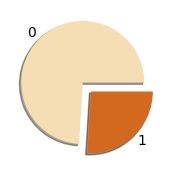

In [611]:
# Show target counts 
plt.figure(figsize=(2,2))
plt.pie(y_data.value_counts(), labels=[0, 1], colors=['wheat', 'chocolate'], explode=[0.1, 0.1], shadow=True)
plt.show()

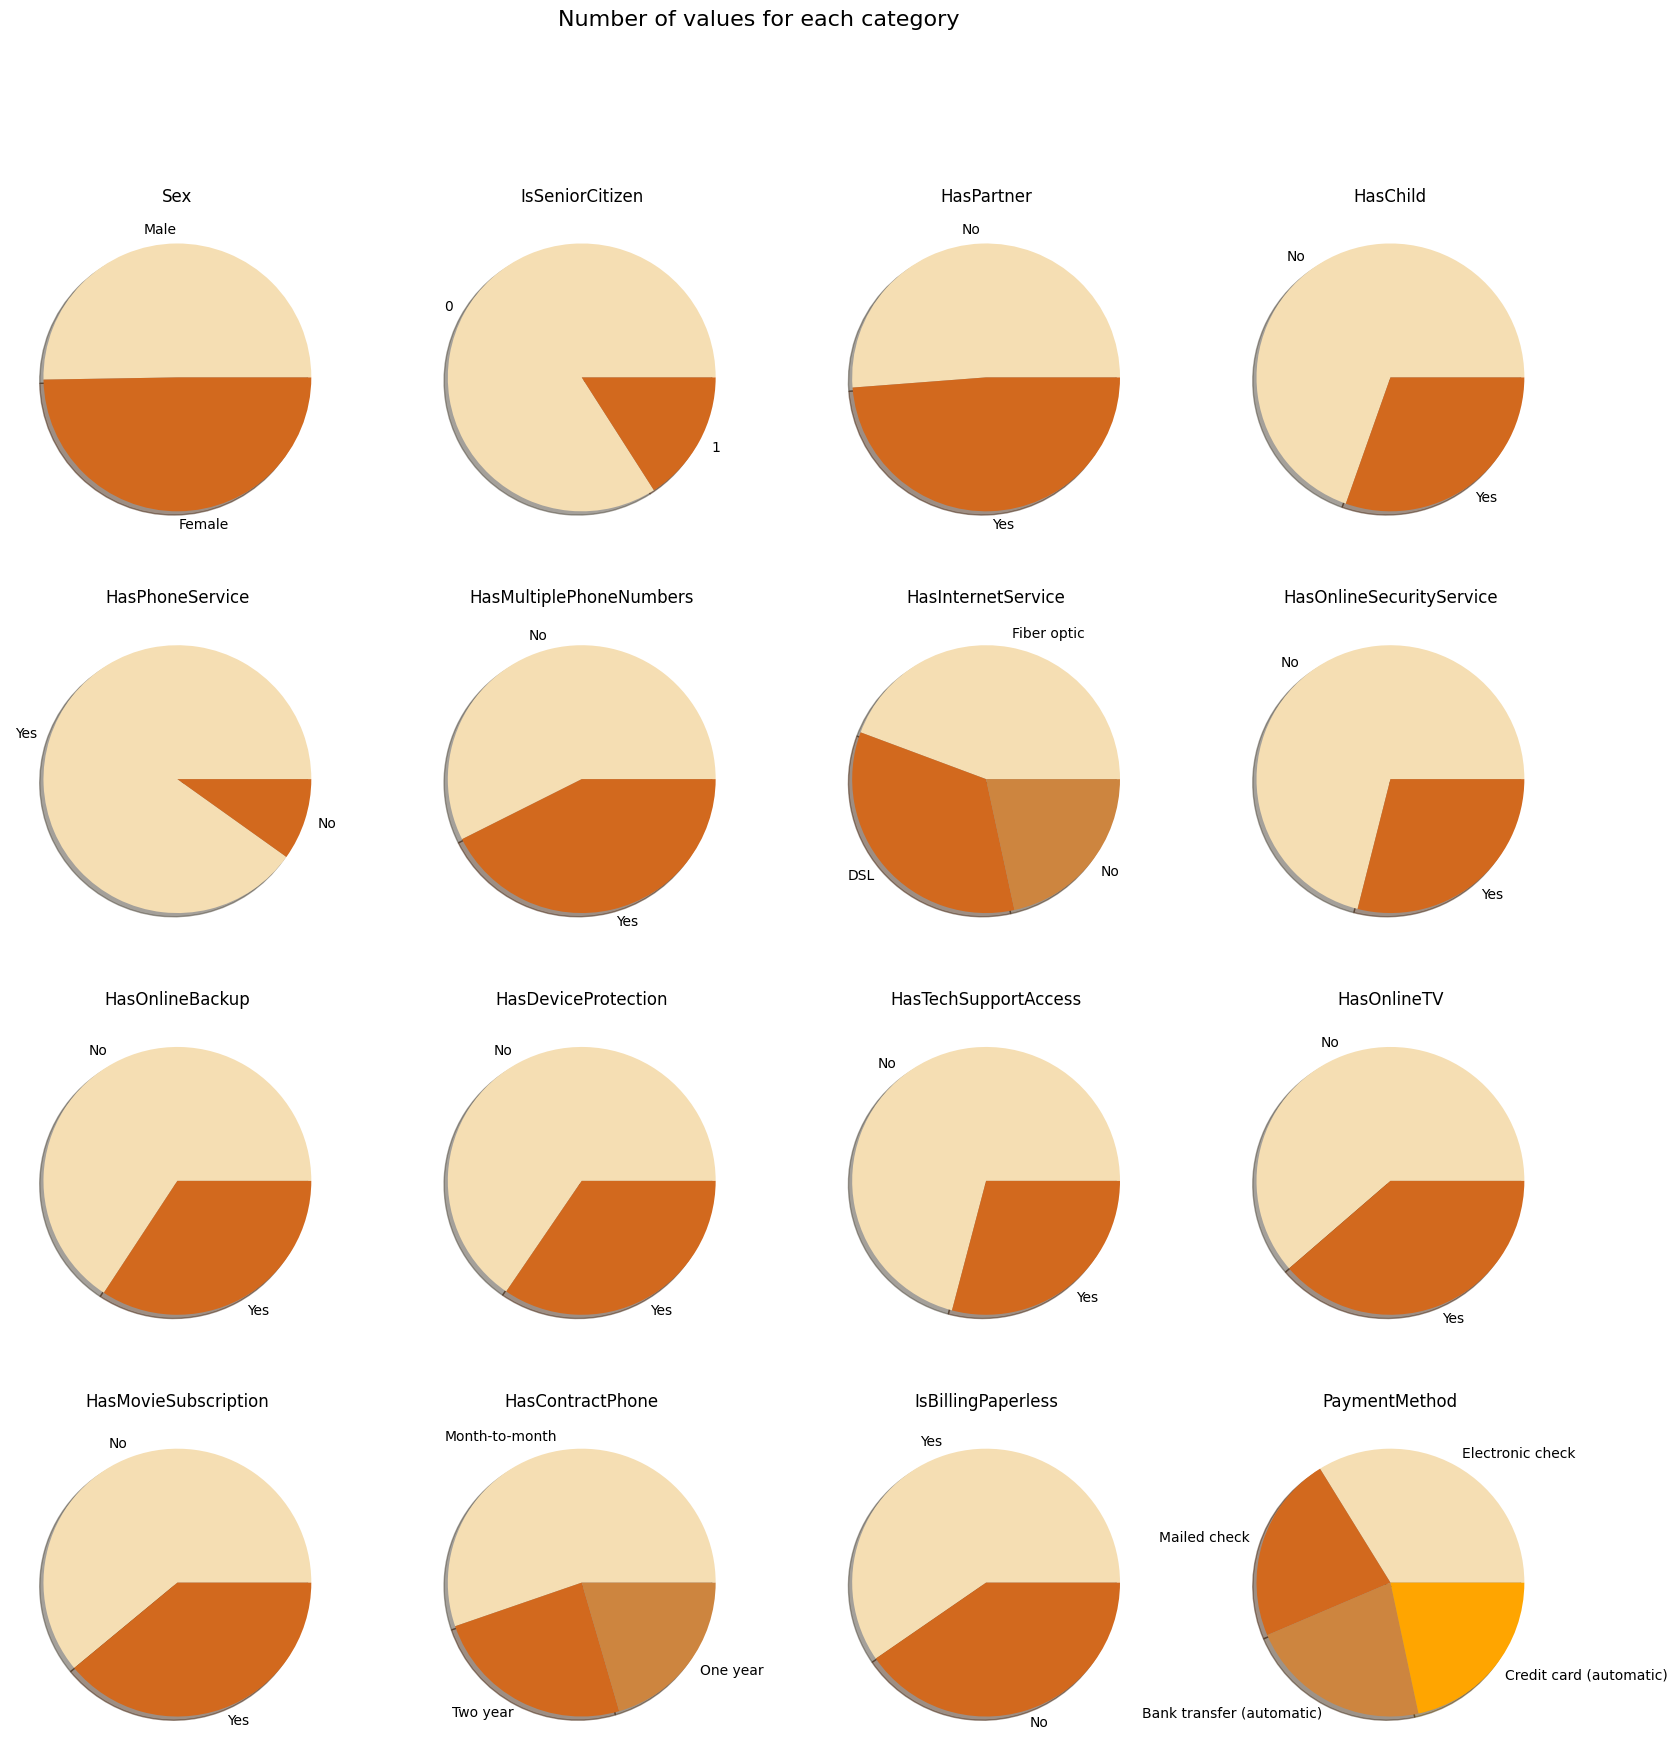

In [612]:
# Show count values for categorical
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
ax = axes.ravel()
fig.suptitle('Number of values for each category', fontsize=16)
for i, cat in enumerate(cat_cols):
    x = outflow_users_df[cat].value_counts()
    index = x.index
    ax[i].pie(labels=index, x=x, colors=['wheat', 'chocolate', 'peru', 'orange'], shadow=True)
    ax[i].set_title(cat)

##### Histogram analysis
Result:
1. The longer the ClientPeriod, the less the Churn. The largest churn of customers is observed in the first months
2. Most regular customers enjoy inexpensive tariffs.
3. Regular customers bring more profit.

Column name: ClientPeriod


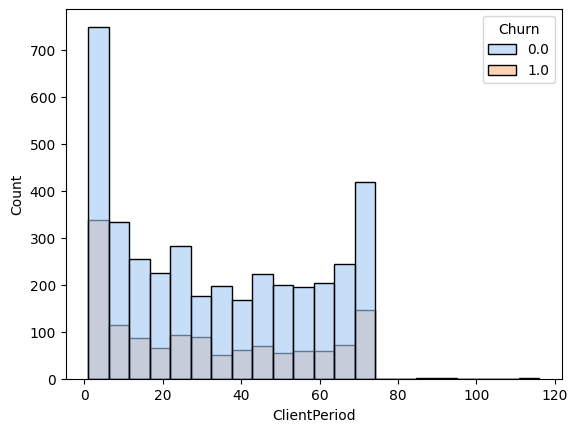

Column name: MonthlySpending


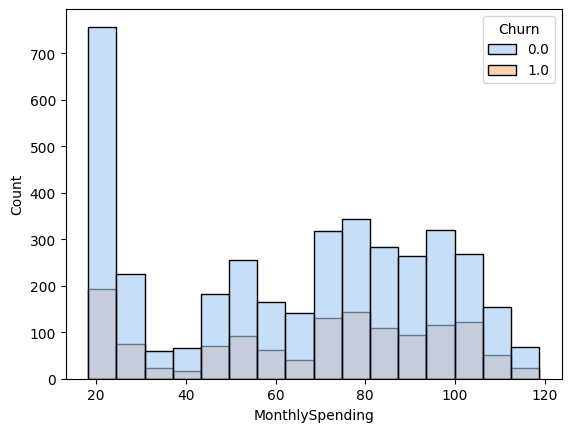

Column name: TotalSpent


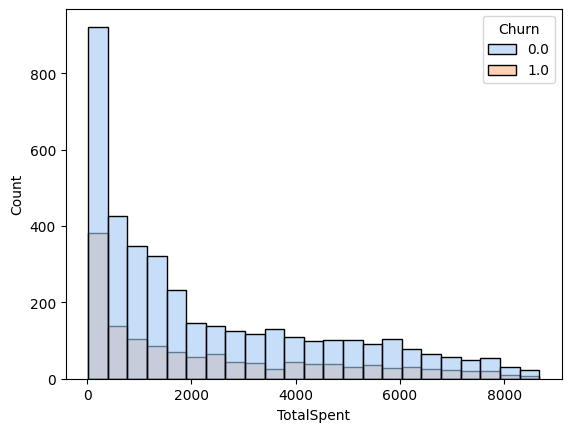

Column name: ClientPeriod


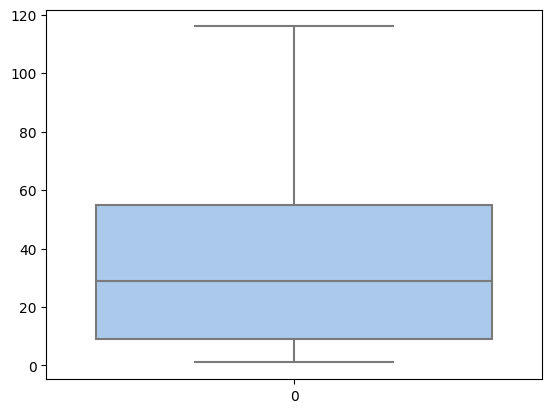

Column name: MonthlySpending


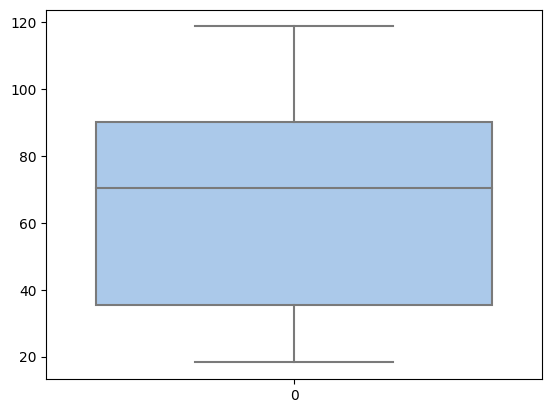

Column name: TotalSpent


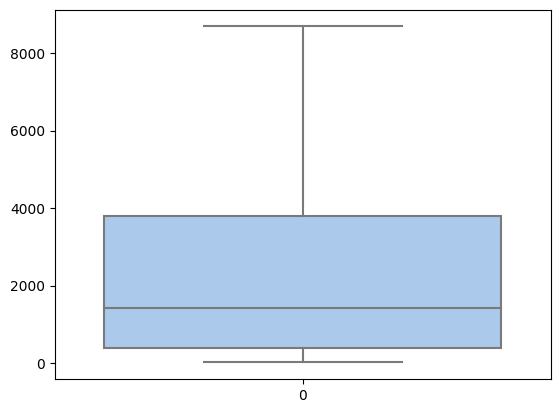

In [613]:
# Show histplot for numeric columns
for column in num_cols:
    print(f"Column name: {column}")
    sns.histplot(data=df_analysis, x=column, hue=target_colname, palette="pastel", alpha=0.6)
    plt.show()

# Show boxplot for numeric columns
for column in num_cols:
    print(f"Column name: {column}")
    sns.boxplot(df_analysis[column], palette='pastel')
    plt.show()

##### Anomaly detection

In [ ]:
# Correct anomaly data
upper_limit_ClientPeriod = 75
df_analysis['ClientPeriod'] = np.where(df_analysis['ClientPeriod'] > upper_limit_ClientPeriod, upper_limit_ClientPeriod, df_analysis['ClientPeriod'])

#### Correlation matrix

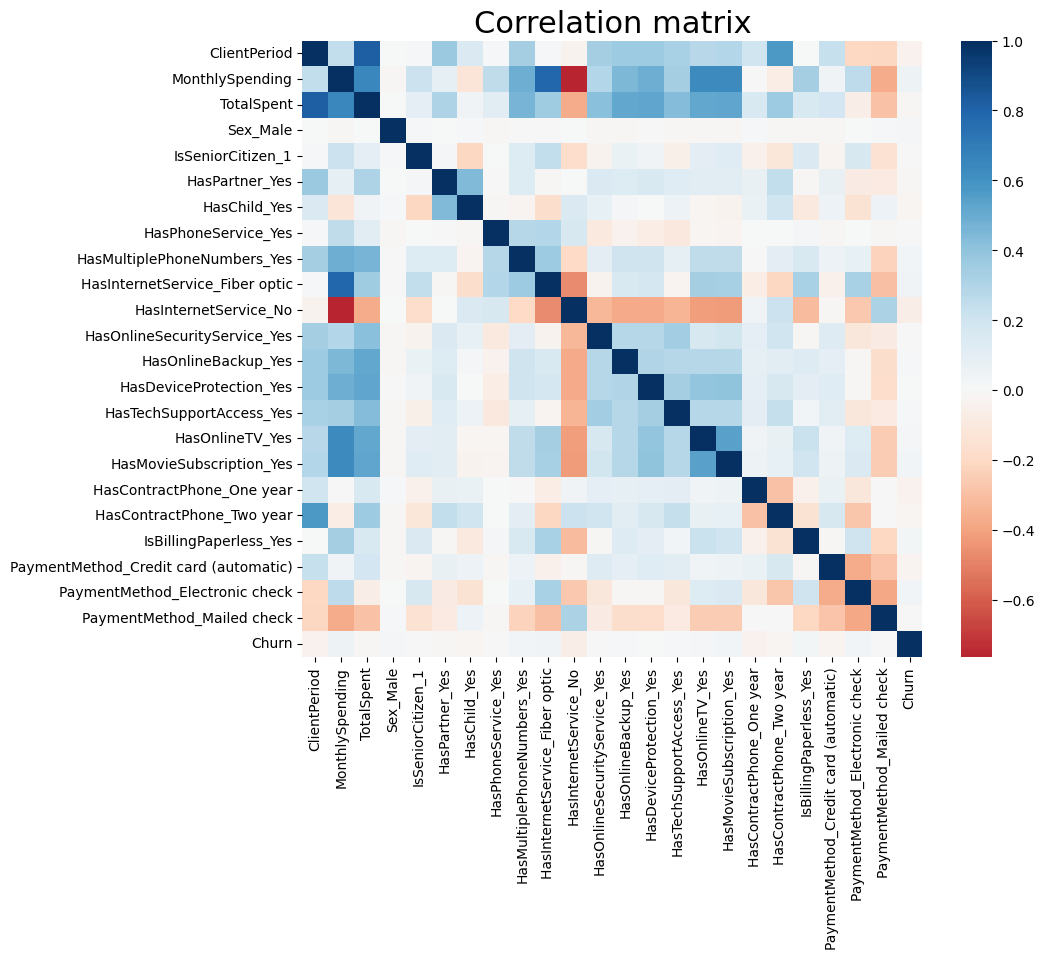

In [615]:
# correlation = pd.concat([x_data,y_data], axis=1).corr()
correlation = df_analysis.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns,
    yticklabels=correlation.columns,
    cmap="RdBu",
    center=0,
)

plt.title("Correlation matrix", fontsize=22)
plt.show()

##### Join preproc columns

In [616]:
# Concatenate OHE columns + numeric columns
x_data = pd.concat([outflow_users_df[num_cols], df_cat_ohe_sklearn],axis=1)
x_data_testfile = pd.concat([test_outflow_users_df[num_cols], df_cat_ohe_sklearn_testfile],axis=1)

y_data = outflow_users_df[target_colname]

# show shape
print(x_data.shape, x_data_testfile.shape, y_data.shape)
x_data.head(3)

(5282, 23) (1761, 23) (5282,)


,ClientPeriod,MonthlySpending,TotalSpent,Sex_Male,IsSeniorCitizen_1,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_Yes,HasInternetService_Fiber optic,...,HasDeviceProtection_Yes,HasTechSupportAccess_Yes,HasOnlineTV_Yes,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55.0,19.50,1026.35,1,0,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,72.0,25.85,1872.20,1,0,1,0,1,1,0,...,0,0,0,0,0,1,0,1,0,0
2,1.0,75.90,75.90,1,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,1,0


##### Train/Test split

In [617]:
# Train/Test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, shuffle=True, random_state=53)

# show shape
print(x_data.shape, y_data.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape)
x_train.head(3)

(5282, 23) (5282,) (4753, 23) (529, 23) (4753,) (529,)


,ClientPeriod,MonthlySpending,TotalSpent,Sex_Male,IsSeniorCitizen_1,HasPartner_Yes,HasChild_Yes,HasPhoneService_Yes,HasMultiplePhoneNumbers_Yes,HasInternetService_Fiber optic,...,HasDeviceProtection_Yes,HasTechSupportAccess_Yes,HasOnlineTV_Yes,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1106,2.0,76.5,162.45,1,0,0,0,1,1,1,...,0,0,0,0,0,0,1,0,1,0
2095,27.0,79.5,2180.55,1,0,0,1,1,1,1,...,0,1,0,0,0,0,1,0,1,0
4469,72.0,104.8,7470.10,1,0,1,0,1,1,1,...,1,0,1,1,0,1,1,0,0,0


##### Normalization Numeric columns 

In [618]:
from sklearn.preprocessing import StandardScaler
if len(num_cols) > 0:
    scaler = StandardScaler()
    # Fit on train data!
    scaler.fit(x_train[num_cols])
    x_train[num_cols] = scaler.transform(x_train[num_cols])
    x_test[num_cols] = scaler.transform(x_test[num_cols])

    scaler_all = StandardScaler()
    scaler_all.fit(x_data[num_cols])
    x_data_normalize = scaler_all.transform(x_data[num_cols])
    x_data_testfile_normalize = scaler_all.transform(x_data_testfile[num_cols])
        
    # show shape
    print(x_data.shape, y_data.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(5282, 23) (5282,) (4753, 23) (529, 23) (4753,) (529,)


### Create models

In [619]:
# load models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
import catboost

##### Search feature importances

0.8626560320469259


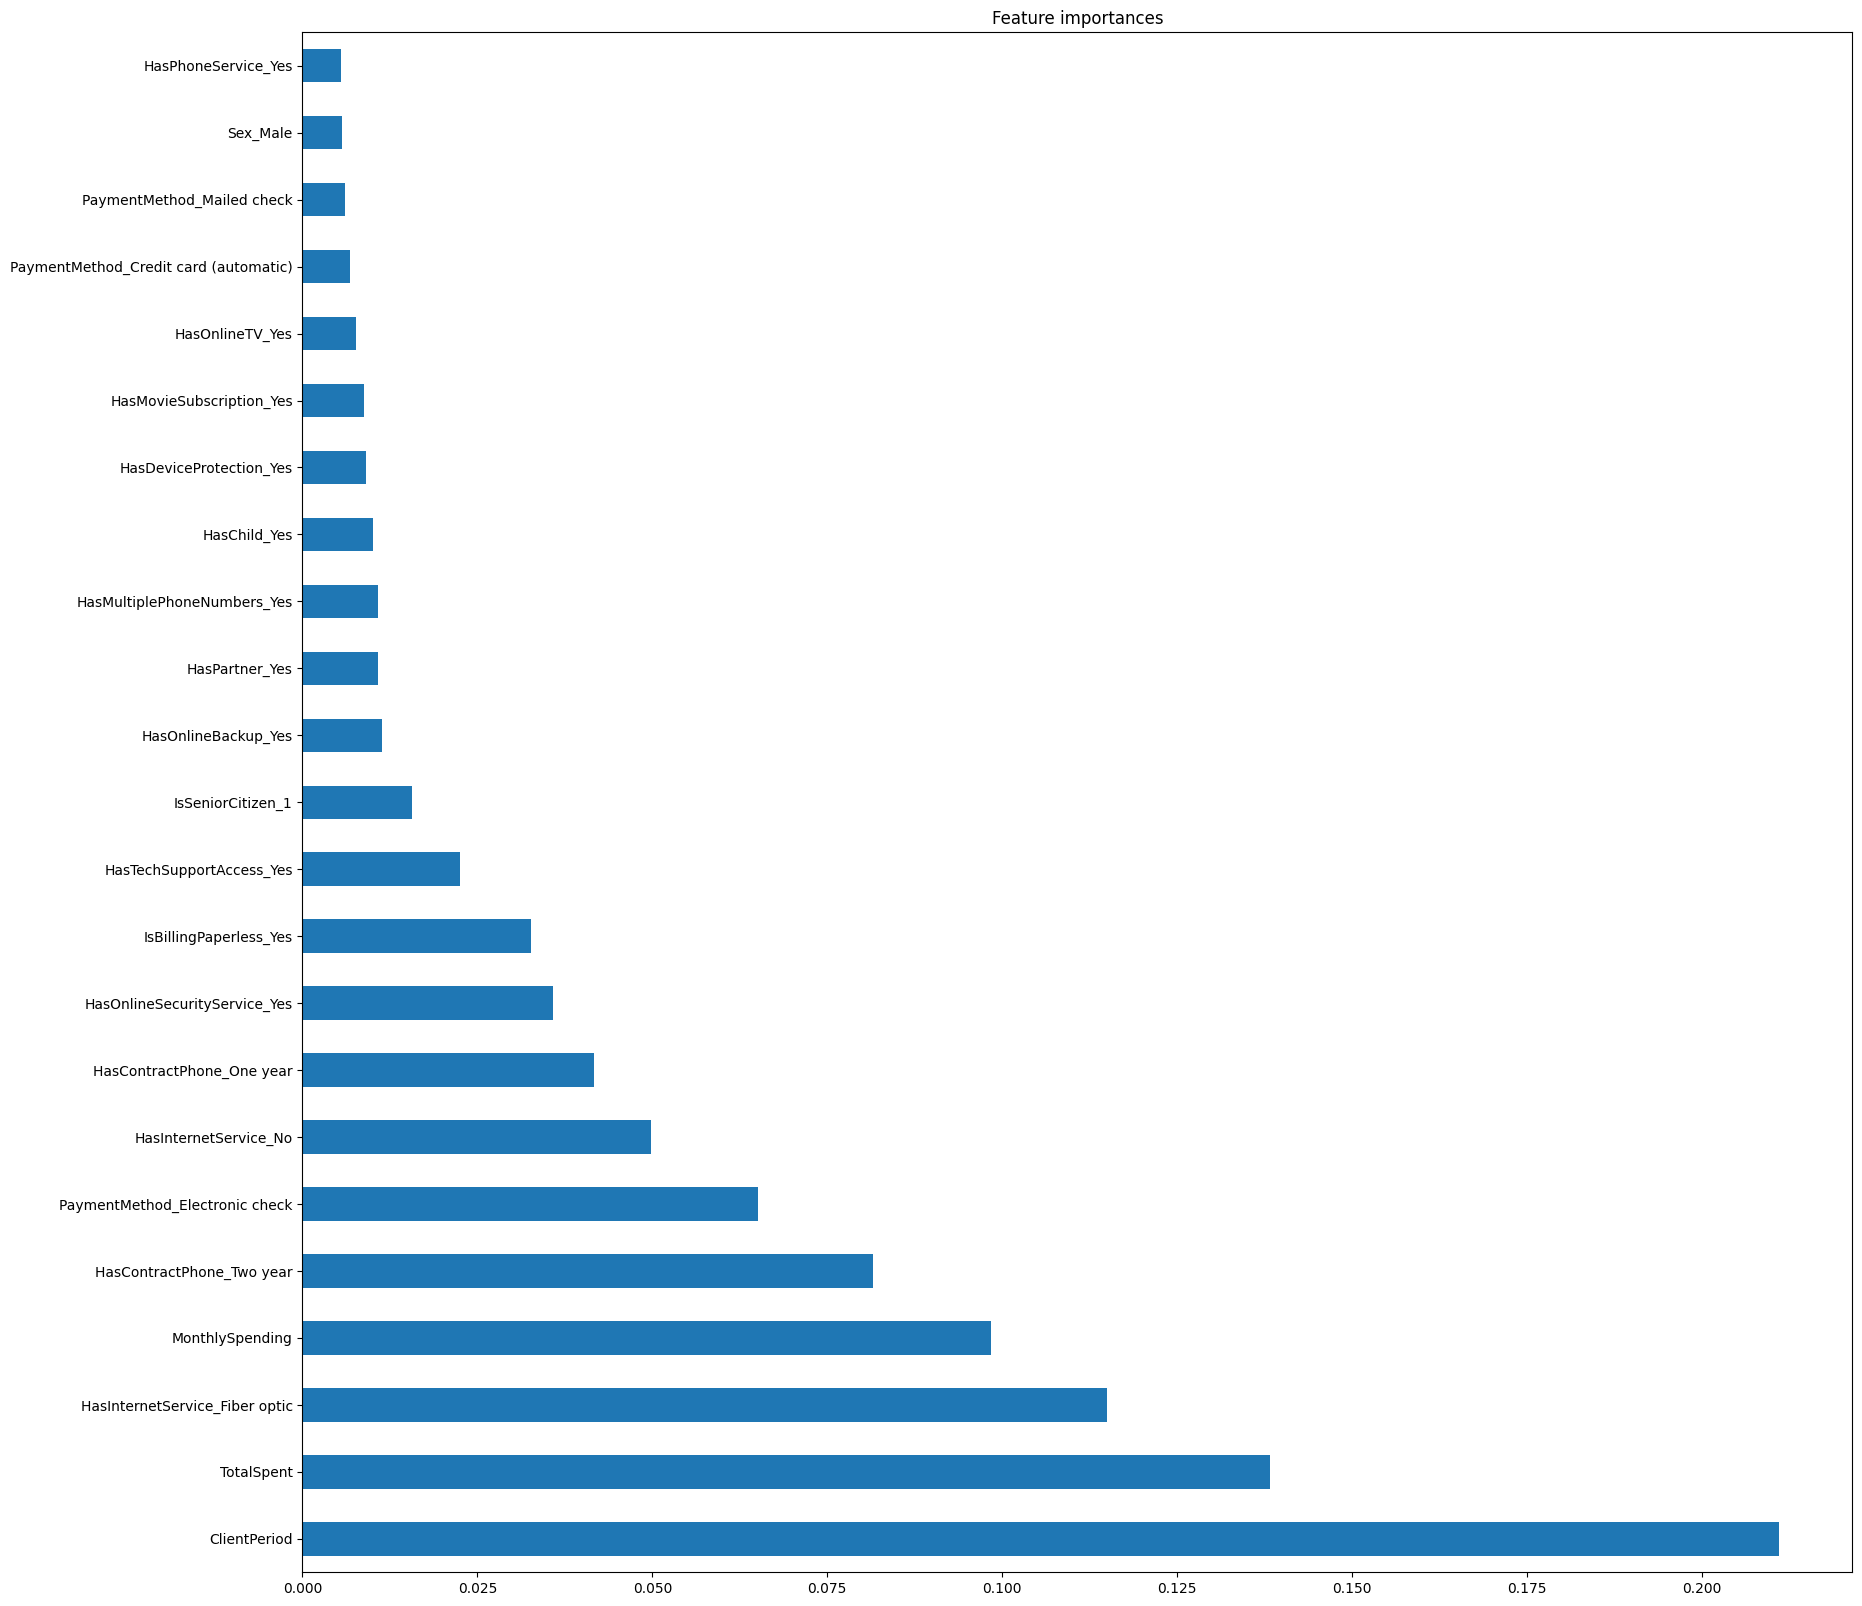

In [620]:
rf_importances = RandomForestClassifier(max_depth=7, n_estimators=200, n_jobs=-1)
rf_importances.fit(x_train, y_train)

predict_rf_importances = rf_importances.predict_proba(x_test)[:, 1]

print(roc_auc_score(y_test, predict_rf_importances))
feat_importances = pd.Series(rf_importances.feature_importances_, index=x_train.columns)
feat_importances.nlargest(x_train.shape[0]).plot(kind='barh', title="Feature importances", figsize=(20,20))
plt.show()

In [621]:
# Choice important features
important_features = ["ClientPeriod", "TotalSpent", "MonthlySpending", "HasInternetService_Fiber optic", "HasContractPhone_Two year", "PaymentMethod_Electronic check", "HasContractPhone_One year", "HasInternetService_No", "HasOnlineSecurityService_Yes", "IsBillingPaperless_Yes", "HasTechSupportAccess_Yes", "IsSeniorCitizen_1", "HasMultiplePhoneNumbers_Yes", "HasChild_Yes", ]
# Check score
rf_importances = RandomForestClassifier(max_depth=7, n_estimators=200, n_jobs=-1)
rf_importances.fit(x_train[important_features], y_train)
predict_rf_importances = rf_importances.predict_proba(x_test[important_features])[:, 1]

logreg = LogisticRegression()
logreg.fit(x_train[important_features], y_train)
predict_logreg_importances = logreg.predict_proba(x_test[important_features])[:, 1]

print(f"ROC-AUC RandomForest: {roc_auc_score(y_test, predict_rf_importances)}, ROC-AUC LogisticRegression: {roc_auc_score(y_test, predict_logreg_importances)}")

ROC-AUC RandomForest: 0.862405665438678, ROC-AUC LogisticRegression: 0.8449694195071354


In [622]:
# Remove duplicates for rows without non important features
# delete duplicates in data from train_file 
# 1. delete full duplicates
x_data_important = pd.concat([x_data[important_features], y_data],axis=1)
x_data_important = x_data_important.drop_duplicates()

# 2. delete equivalent features with other targets!
mask_duplicate_rows = x_data_important.drop(target_colname, axis=1).duplicated()
x_data_important = x_data_important[~mask_duplicate_rows].reset_index()

# select y_data, x_data
y_data = x_data_important[target_colname]
x_data_important = x_data_important[important_features]

# testfile data select only important features
x_data_important_testfile = x_data_testfile[important_features]


# Train/Test split
x_train, x_test, y_train, y_test = train_test_split(x_data_important, y_data, test_size=0.1, shuffle=True, random_state=53)

x_data_important.shape, y_data.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((5230, 14), (5230,), (4707, 14), (523, 14), (4707,), (523,))

###   Models analysis 

In [623]:
# Selection of hyperparameter C
from sklearn.linear_model import LogisticRegressionCV
hparameter_C = [100, 10, 1, 0.1, 0.01, 0.001]
log_reg_cv = LogisticRegressionCV(Cs=hparameter_C, scoring='roc_auc', refit=True, n_jobs=-1)
log_reg_cv.fit(x_train, y_train)

# get score roc_auc:
auc_score_v1 = log_reg_cv.score(x_test, y_test)
predict_log_reg_cv = log_reg_cv.predict_proba(x_test)[:,1]
auc_score_v2 = roc_auc_score(y_test, predict_log_reg_cv)

print(f"ROC AUC Score. calc score v1:{auc_score_v1}, calc score v2: {auc_score_v2}, v1==v2: {auc_score_v1 == auc_score_v2}")
print(f"Best C parameters from ({hparameter_C}): {log_reg_cv.C_}")

ROC AUC Score. calc score v1:0.8602977667493796, calc score v2: 0.8602977667493796, v1==v2: True
Best C parameters from ([100, 10, 1, 0.1, 0.01, 0.001]): [1.]


In [624]:
# Select the best parameters for RandomForestClassifier
from sklearn.model_selection import GridSearchCV
# set parameters
param_grid = {
    "max_depth": np.arange(3, 10, 3),
    "n_estimators": np.arange(200, 400, 50),
    "min_samples_split": np.arange(2, 6, 2),
    "bootstrap": [True, False],
}
# create and fit GridSearchCV model
rfc=RandomForestClassifier(n_estimators=200, random_state=42, criterion="entropy")
model = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc', refit=True, n_jobs=-1, verbose=3)
model.fit(x_train, y_train)

# Show best parameters
print("Best ROC-AUC metric:", model.best_score_)
print("Best estimator's parameters:", model.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best ROC-AUC metric: 0.8435295790339079
Best estimator's parameters: {'bootstrap': True, 'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 300}


##### Stacking

In [625]:
catboost_model = catboost.CatBoostClassifier(n_estimators=200, silent=True, eval_metric='AUC',loss_function = "CrossEntropy")
rand_forest_3 = RandomForestClassifier(max_depth=3, n_estimators=200, bootstrap=True, criterion="entropy", min_samples_split=2, n_jobs=-1)
rand_forest_7 = RandomForestClassifier(max_depth=7, n_estimators=200, bootstrap=True, criterion="entropy", min_samples_split=2, n_jobs=-1)
rand_forest_10 = RandomForestClassifier(max_depth=10, n_estimators=200, bootstrap=True, criterion="entropy", min_samples_split=2, n_jobs=-1)
# rand_forest_3 = RandomForestClassifier(max_depth=3, n_estimators=200, 'bootstrap': True, 'criterion': 'entropy', 'min_samples_split': 2, n_jobs=-1)
# rand_forest_7 = RandomForestClassifier(max_depth=7, n_estimators=200, n_jobs=-1)
# rand_forest_10 = RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1)

models = [
    catboost_model,    
    rand_forest_3,
    rand_forest_7,
    rand_forest_10,
    ]

train_features_model_predicts = np.zeros(x_data_important.shape[0])[...,None]
test_features_model_predicts = np.zeros(x_data_important_testfile.shape[0])[...,None]

for model in models:
    print(f"model: {model}")
    model.fit(x_data_important, y_data)
    cv_predict = cross_val_predict(model, x_data_important, y_data, cv=5, method="predict_proba")
        
    predict_test = model.predict_proba(x_data_important_testfile)
    train_features_model_predicts = np.concatenate((train_features_model_predicts, cv_predict[:, -1][...,None]), axis=1)
    test_features_model_predicts = np.concatenate((test_features_model_predicts, predict_test[:, -1][...,None]), axis=1)
    
train_features_model_predicts = train_features_model_predicts[:,1:]
test_features_model_predicts = test_features_model_predicts[:,1:]
    
stacking_model = LogisticRegression(penalty='l2', C=1, max_iter=30)
stacking_model.fit(train_features_model_predicts, y_data)

predict_stacking_model_proba = stacking_model.predict_proba(test_features_model_predicts)[:, 1]

# Write submission
predict_df = pd.DataFrame(predict_stacking_model_proba)
predict_df = pd.concat([pd.DataFrame(predict_df.index.values), predict_df], axis=1)
predict_df.to_csv(PATH_DATASET + "stacking_important_submission.csv", sep=",", index=False, header=["Id","Churn"])

model: <catboost.core.CatBoostClassifier object at 0x00000297989E66C8>
model: RandomForestClassifier(criterion='entropy', max_depth=3, n_estimators=200,
                       n_jobs=-1)
model: RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=200,
                       n_jobs=-1)
model: RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=200,
                       n_jobs=-1)


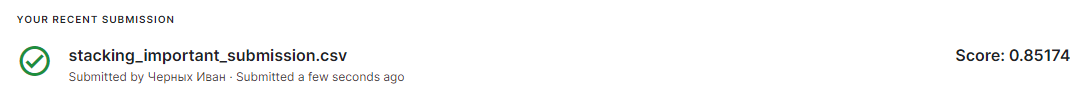